In [1]:
import numpy as np
import matplotlib.pyplot as plt

from langevian_protein import run

In [2]:
residues = ['H', 'P', 'P', 'H', 'H']
coordinates = np.array([
    [0,0,1],
    [0,0,2],
    [0,0,3],
    [0,0,4],
    [0,0,5]
])
friction = 0.05
m = 1
kT = 2
dt = 0.003
k = 20
l = 1
iterations = 10000

In [4]:
potential_record, kinetic_record, energies, temperatures, total_forces, velocities, current_state = run(coordinates, m, residues, k, l, friction, kT, dt, iterations)

-0.12764353153947883 23.080534295179373 22.952890763639893
4.255193525849186 18.72940021451574 22.984593740364925
1.307126227332877 19.62321360030119 20.930339827634068
7.109244598428309 9.985949396265905 17.095193994694213
2.022278072665073 9.84650239172365 11.868780464388724
3.54378733211985 10.172941618359499 13.716728950479348
3.7643360687417147 13.472862100114847 17.237198168856562
1.5808793146728695 12.692592639989332 14.273471954662202
0.7004937980327903 11.604392350253146 12.304886148285936
4.387972267856657 8.611868178014998 12.999840445871655


[]

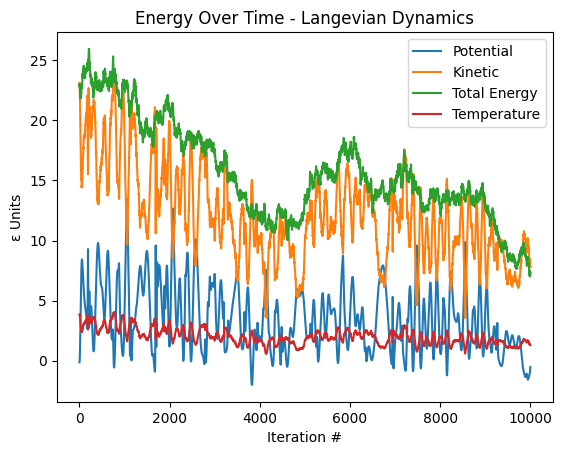

In [10]:
plt.figure()
x = [x for x in range(iterations+1)]
plt.plot(x, potential_record, label="Potential")
plt.plot(x, kinetic_record, label="Kinetic")
plt.plot(x, energies, label="Total Energy")
plt.plot(x, temperatures, label="Temperature")
plt.legend()
plt.xlabel("Iteration #")
plt.ylabel("ε Units")
plt.title("Energy Over Time - Langevian Dynamics")
plt.savefig("../../data/LangevianEnergy.png")
plt.plot()

In [12]:
print("Average Energy over last 1000 time steps: ")
print("Potential: ", np.mean(potential_record[-1000:]))
print("Kinetic: ", np.mean(kinetic_record[-1000:]))

Average Energy over last 1000 time steps: 
Potential:  1.1880602033466718
Kinetic:  8.477691362719415
